In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import jsonify

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect = True)
# reflect the tables

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
year_from_last_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_from_last_date)

('2017-08-23',)
2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
year_prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_from_last_date).all()
print(year_prcp_data)

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_prcp_data, columns = ("Date", "Precipation"))
index_df = df.set_index("Date")
index_df.head()

,Precipation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
sorted_df = index_df.sort_index()
sorted_df

,Precipation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [16]:
# Dropped NA values from sorted DataFrame
dropped_df = sorted_df.dropna()

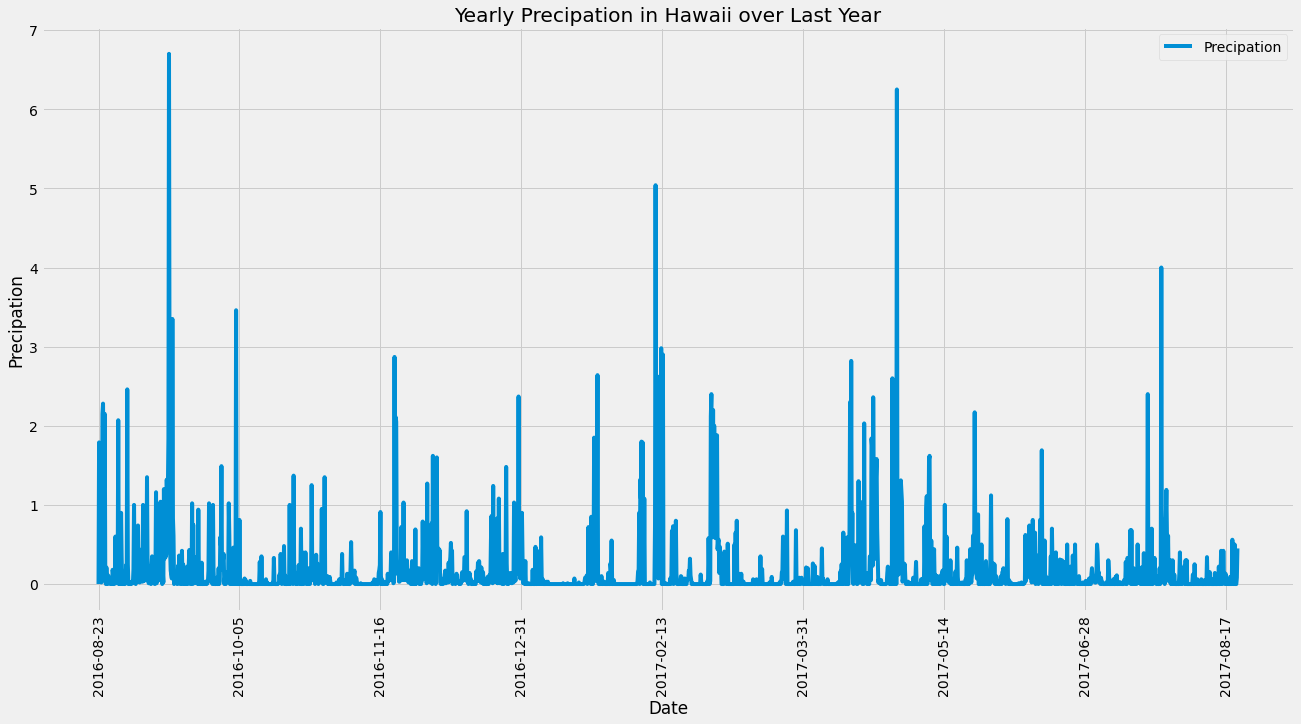

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
dropped_df.plot(rot = 90, ylabel = "Precipation", title = "Yearly Precipation in Hawaii over Last Year", figsize = (20,10))
plt.savefig('Images/Yearly_Precipation')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
agg_df = dropped_df.describe(percentiles=[0.25, 0.5, 0.75])
agg_df.head(10)

,Precipation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = len(session.query(Measurement.station).group_by(Measurement.station).all())
print(number_of_stations)

9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
display(stations)
most_active_station = stations[0][0]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sell = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp_data = session.query(*sell).filter(Measurement.station == most_active_station).all()
temp_df = pd.DataFrame(temp_data, columns = ("Station", "Min Temp (degrees F)", "Max Temp (degrees F)",
                                             "Avgerage Temp (degrees F)"))
temp_df = temp_df.set_index("Station")
temp_df.head()

,Min Temp (degrees F),Max Temp (degrees F),Avgerage Temp (degrees F)
Station,,,
USC00519281,54.0,85.0,71.663781


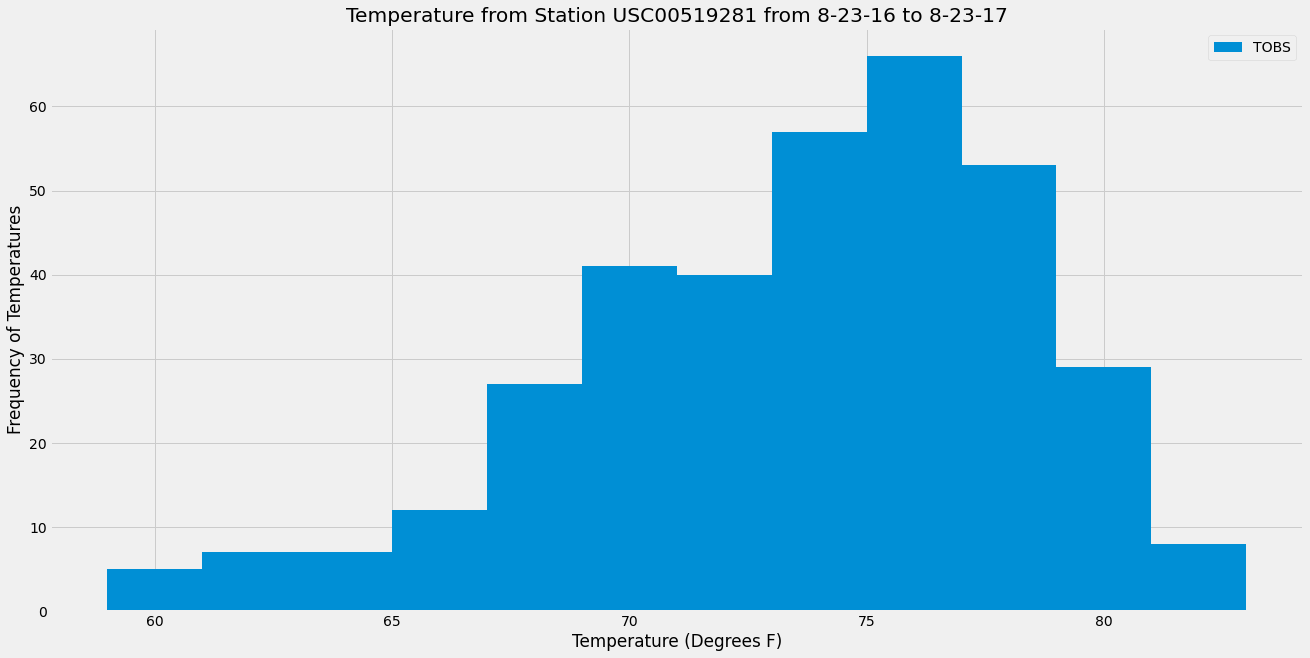

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_active = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= year_from_last_date).all()
station_temps_df = pd.DataFrame(tobs_active, columns = ("Station", "TOBS"))
station_temps_df = station_temps_df.set_index("Station")
station_temps_df.hist("TOBS", bins = 12, figsize = (20,10), legend = True)
plt.title("Temperature from Station USC00519281 from 8-23-16 to 8-23-17")
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Frequency of Temperatures")
plt.savefig('Images/Precipitation_Histogram_1YR')
plt.show()

In [23]:
sel_min = [Measurement.date, Measurement.station, func.min(Measurement.tobs),]
sel_max = [Measurement.date, Measurement.station, func.max(Measurement.tobs)]
sel_avg = [func.avg(Measurement.tobs)]
temperatures_min = session.query(*sel_min).filter(Measurement.date.between(dt.date(2017,1,1), dt.date(2017,1,2))).all()
temperatures_max = session.query(*sel_max).filter(Measurement.date.between(dt.date(2017,1,1), dt.date(2017,1,2))).all()
temperatures_avg = session.query(*sel_avg).filter(Measurement.date.between(dt.date(2017,1,1), dt.date(2017,1,2))).all()
temperatures_agg = temperatures_min, temperatures_max, temperatures_avg
# for date, station, tmin in temperatures_agg:
#     temperatures_dict = {}
#     temperatures_dict["date"] = date
#     temperatures_dict["station"] = station
#     temperatures_dict["timn"] = tmin
#     temperature_list.append(temperatures_dict)
print(temperatures_agg)

([('2017-01-01', 'USC00519397', 62.0)], [('2017-01-01', 'USC00514830', 74.0)], [(69.27272727272727,)])


## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_yr_temps = calc_temps('2016-11-20','2016-11-30')
print(prev_yr_temps)

[(67.0, 74.32352941176471, 80.0)]


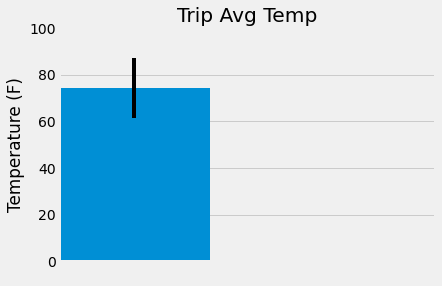

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x = " ", height = prev_yr_temps[0][1], yerr = (prev_yr_temps[0][2] - prev_yr_temps[0][0]), align = 'edge')
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xlim(0, 2)
plt.ylim(0,100)
plt.savefig('Images/Trip_Avg_Temp')
plt.show()


In [59]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = "2016-11-20"
trip_end = "2016-11-30"
selection = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude,Station.elevation]
trip_rain1 = session.query(*selection).\
            filter(Measurement.station == Station.station).filter(Measurement.date.between(trip_start,trip_end)).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_df1 = pd.DataFrame(trip_rain1, columns = ("Station", "Precipation from 11-20-16 to 11-30-16 (in)", "Station Location", "Latitude", "Longitude", "Elevation"))
display(rainfall_df1)

,Station,Precipation from 11-20-16 to 11-30-16 (in),Station Location,Latitude,Longitude,Elevation
0,USC00516128,9.22,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.55,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00519523,1.22,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00513117,1.04,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519397,0.63,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00514830,0.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [60]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [82]:
# calculate the daily normals for your trip
normals = []
trip_dates_list = ["11-20","11-21","11-23","11-24","11-25","11-26","11-27","11-28","11-29","11-30"]
for each_date in trip_dates_list:
    normals.append(daily_normals(each_date))
normals
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[[(67.0, 73.03921568627452, 80.0)],
 [(66.0, 73.34, 81.0)],
 [(64.0, 72.2, 80.0)],
 [(66.0, 72.56521739130434, 77.0)],
 [(63.0, 72.43181818181819, 78.0)],
 [(67.0, 73.51063829787235, 78.0)],
 [(63.0, 73.03921568627452, 78.0)],
 [(62.0, 72.75510204081633, 80.0)],
 [(62.0, 71.01960784313725, 79.0)],
 [(61.0, 71.8076923076923, 79.0)]]

In [106]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_df = pd.DataFrame((normals[0][0],normals[1][0],normals[2][0],normals[3][0],normals[4][0],normals[5][0],
             normals[6][0],normals[7][0],normals[8][0],normals[9][0]), 
             columns = ("Historical_Temp_Min","Historical_Temp_Avg", "Historical_Temp_Max" ), index = trip_dates_list)
display(trip_temp_df)

,Historical_Temp_Min,Historical_Temp_Avg,Historical_Temp_Max
11-20,67.0,73.039216,80.0
11-21,66.0,73.340000,81.0
11-23,64.0,72.200000,80.0
11-24,66.0,72.565217,77.0
11-25,63.0,72.431818,78.0
11-26,67.0,73.510638,78.0
11-27,63.0,73.039216,78.0
11-28,62.0,72.755102,80.0
11-29,62.0,71.019608,79.0
11-30,61.0,71.807692,79.0


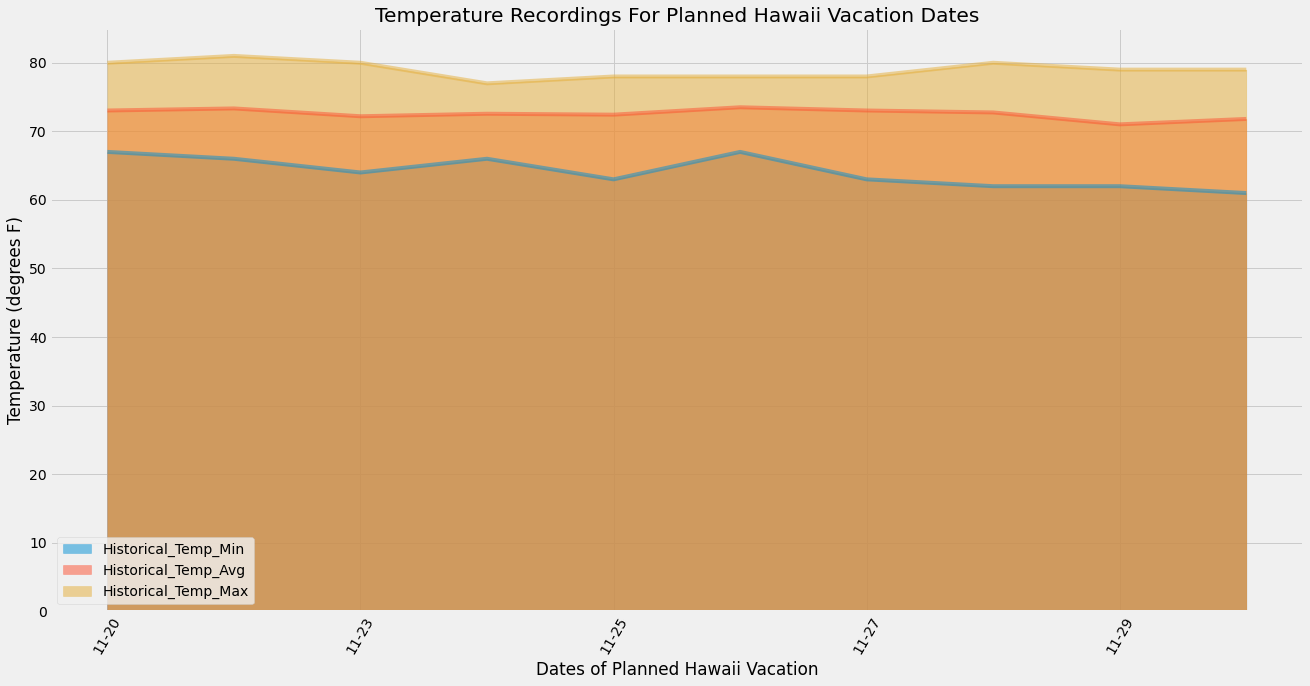

In [113]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_df.plot.area(stacked = False, rot = 60, figsize = (20,10))
plt.title("Temperature Recordings For Planned Hawaii Vacation Dates")
plt.xlabel("Dates of Planned Hawaii Vacation")
plt.ylabel("Temperature (degrees F)")
plt.savefig("Images/Historical_Temperature_Data_for_Hawaii_Trip")
plt.show()